# Hybrid ML Trading Strategy - Complete Pipeline

This notebook implements a complete machine learning-based trading strategy:

## Strategy Overview:
1. **Data Split**: 30% for ML training, 70% for backtesting (chronological)
2. **ML Training**: Train regime classifiers on 30% of data
3. **Regime Prediction**: Use trained ML models to predict regimes on 70% test data
4. **Trading Strategy**: Apply regime-specific strategies based on ML predictions
5. **Transaction Costs**: 0.75% commission + 0.01% slippage
6. **Trade Logging**: Save all trades to /models/trade_logs

## Workflow:
- Load and split data chronologically (30/70)
- Engineer 80+ features for ML training
- Train Random Forest, Gradient Boosting, and SVM classifiers
- Predict regimes on test data using best model
- Execute hybrid trading strategy with regime-specific rules
- Analyze performance with comprehensive metrics
- Save trade logs and visualizations

## 1. Imports and Setup

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os
import json

# ML imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

print("All imports successful")

All imports successful


## 2. Data Loading and 30/70 Split

In [2]:
def load_and_split_dataset(train_ratio=0.3):
    """
    Load 1D momentum regime dataset and split chronologically for ML training
    
    Args:
        train_ratio: Fraction of data to use for training (default 0.3 = 30%)
    
    Returns:
        train_df: First 30% of data for ML training
        test_df: Last 70% of data for backtesting
        full_df: Complete dataset for reference
    """
    data_dir = '../data'
    filename = 'BTCUSD_2023_1min_enhanced_regimes_1D_momentum.csv'
    filepath = os.path.join(data_dir, filename)
    
    if not os.path.exists(filepath):
        print(f"Error: {filepath} not found")
        return None, None, None
    
    print("Loading 1D momentum regime dataset...")
    df = pd.read_csv(filepath)
    
    # Handle timestamp and ensure chronological order
    timestamp_col = 'timestamp' if 'timestamp' in df.columns else 'Timestamp'
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df = df.set_index(timestamp_col).sort_index()
    
    # Clean up
    cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=cols_to_drop)
    
    print(f"Dataset loaded: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    
    # Chronological split - CRITICAL: First 30% for training, Last 70% for testing
    split_idx = int(len(df) * train_ratio)
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    
    print(f"\nTrain/Test Split (Chronological):")
    print(f"Training: {train_df.shape} ({train_ratio*100:.0f}%) | {train_df.index.min()} to {train_df.index.max()}")
    print(f"Testing:  {test_df.shape} ({(1-train_ratio)*100:.0f}%) | {test_df.index.min()} to {test_df.index.max()}")
    
    # Verify no data leakage
    assert train_df.index.max() < test_df.index.min(), "Data leakage detected!"
    
    return train_df, test_df, df

# Load and split data
train_df, test_df, full_df = load_and_split_dataset(train_ratio=0.3)

Loading 1D momentum regime dataset...
Dataset loaded: (434438, 33)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00

Train/Test Split (Chronological):
Training: (130331, 33) (30%) | 2023-02-10 00:00:00 to 2023-05-15 21:34:00
Testing:  (304107, 33) (70%) | 2023-05-15 21:35:00 to 2023-12-31 14:27:00


## 3. Feature Engineering for ML Training

In [3]:
def engineer_ml_features(df, lookback_windows=[5, 10, 20, 50]):
    """
    Engineer comprehensive features for ML regime classification
    
    Args:
        df: DataFrame with OHLCV and technical indicators
        lookback_windows: Different window periods for feature engineering
        
    Returns:
        DataFrame with engineered features ready for ML training
    """
    df = df.copy()
    
    print("Engineering features for ML training...")
    
    # 1. Price-based features
    print("  - Price-based features")
    for window in lookback_windows:
        # Returns and volatility
        df[f'return_{window}d'] = df['Close'].pct_change(window)
        df[f'volatility_{window}d'] = df['Close'].pct_change().rolling(window).std()
        
        # Trend strength
        df[f'trend_strength_{window}d'] = (df['Close'] - df['Close'].shift(window)) / df['Close'].shift(window)
        
        # Price position relative to moving averages
        if f'sma_{window}d' in df.columns:
            df[f'price_vs_sma_{window}d'] = (df['Close'] - df[f'sma_{window}d']) / df[f'sma_{window}d']
        if f'ema_{window}d' in df.columns:
            df[f'price_vs_ema_{window}d'] = (df['Close'] - df[f'ema_{window}d']) / df[f'ema_{window}d']
    
    # 2. Technical indicator features
    print("  - Technical indicator features")
    
    # RSI features
    if 'rsi_14d' in df.columns:
        df['rsi_normalized'] = (df['rsi_14d'] - 50) / 50  # Normalize around neutral
        df['rsi_momentum'] = df['rsi_14d'].diff()
        df['rsi_oversold'] = (df['rsi_14d'] < 30).astype(int)
        df['rsi_overbought'] = (df['rsi_14d'] > 70).astype(int)
    
    # MACD features
    if 'macd_hist_12_26' in df.columns:
        df['macd_trend'] = np.where(df['macd_hist_12_26'] > 0, 1, -1)
        df['macd_momentum'] = df['macd_hist_12_26'].diff()
        df['macd_strength'] = abs(df['macd_hist_12_26'])
        
        if 'macd_12_26' in df.columns and 'macd_sig_12_26' in df.columns:
            df['macd_signal_cross'] = (df['macd_12_26'] > df['macd_sig_12_26']).astype(int)
    
    # Bollinger Bands features
    if all(col in df.columns for col in ['bb_upper_20d', 'bb_mid_20d', 'bb_lower_20d']):
        df['bb_position'] = (df['Close'] - df['bb_lower_20d']) / (df['bb_upper_20d'] - df['bb_lower_20d'])
        df['bb_squeeze'] = (df['bb_upper_20d'] - df['bb_lower_20d']) / df['bb_mid_20d']
        df['bb_breakout_upper'] = (df['Close'] > df['bb_upper_20d']).astype(int)
        df['bb_breakout_lower'] = (df['Close'] < df['bb_lower_20d']).astype(int)
    
    # 3. Moving average relationships
    print("  - Moving average relationships")
    ma_pairs = [(7, 20), (7, 30), (20, 30)]
    for fast, slow in ma_pairs:
        if f'ema_{fast}d' in df.columns and f'ema_{slow}d' in df.columns:
            df[f'ema_{fast}_{slow}_cross'] = (df[f'ema_{fast}d'] > df[f'ema_{slow}d']).astype(int)
            df[f'ema_{fast}_{slow}_spread'] = (df[f'ema_{fast}d'] - df[f'ema_{slow}d']) / df[f'ema_{slow}d']
        
        if f'sma_{fast}d' in df.columns and f'sma_{slow}d' in df.columns:
            df[f'sma_{fast}_{slow}_cross'] = (df[f'sma_{fast}d'] > df[f'sma_{slow}d']).astype(int)
            df[f'sma_{fast}_{slow}_spread'] = (df[f'sma_{fast}d'] - df[f'sma_{slow}d']) / df[f'sma_{slow}d']
    
    # 4. Volume features
    print("  - Volume features")
    if 'Volume' in df.columns:
        df['volume_sma_20'] = df['Volume'].rolling(20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_sma_20']
        df['volume_momentum'] = df['Volume'].pct_change(5)
        df['high_volume'] = (df['volume_ratio'] > 2).astype(int)
    
    # 5. Fractal dimension features
    print("  - Fractal dimension features")
    if 'fd_14d' in df.columns:
        df['fd_trend'] = df['fd_14d'].diff()
        df['fd_normalized'] = (df['fd_14d'] - df['fd_14d'].rolling(50).mean()) / df['fd_14d'].rolling(50).std()
        
        if 'fd_7d' in df.columns and 'fd_30d' in df.columns:
            df['fd_short_long'] = df['fd_7d'] - df['fd_30d']
            df['fd_complexity'] = (df['fd_14d'] > 1.5).astype(int)  # High complexity indicator
    
    # 6. Momentum and trend features
    print("  - Momentum and trend features")
    
    # Price momentum
    for period in [3, 5, 10]:
        df[f'momentum_{period}d'] = df['Close'].pct_change(period)
        df[f'momentum_{period}d_rank'] = df[f'momentum_{period}d'].rolling(50).rank(pct=True)
    
    # Trend consistency
    df['trend_consistency_5d'] = df['Close'].rolling(5).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    df['trend_consistency_10d'] = df['Close'].rolling(10).apply(lambda x: 1 if x.is_monotonic_increasing else (-1 if x.is_monotonic_decreasing else 0))
    
    # 7. Volatility regime features
    print("  - Volatility regime features")
    
    # Rolling volatility
    for window in [10, 20, 30]:
        rolling_vol = df['Close'].pct_change().rolling(window).std()
        df[f'volatility_{window}d'] = rolling_vol
        df[f'volatility_{window}d_rank'] = rolling_vol.rolling(100).rank(pct=True)
        df[f'high_volatility_{window}d'] = (rolling_vol > rolling_vol.rolling(100).quantile(0.8)).astype(int)
    
    # 8. Multi-timeframe features (if available)
    print("  - Multi-timeframe features")
    timeframe_cols = [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    for col in timeframe_cols:
        if col in df.columns:
            # Count regime consistency across timeframes
            df[f'{col}_consistency'] = (df[col] == df['regime']).astype(int)
    
    # 9. Lag features for temporal patterns
    print("  - Lag features")
    key_features = ['rsi_14d', 'macd_hist_12_26', 'bb_position']
    for feature in key_features:
        if feature in df.columns:
            for lag in [1, 2, 3, 5]:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    print(f"Feature engineering complete. Shape: {df.shape}")
    
    return df

def prepare_ml_data(df, target_col='regime'):
    """
    Prepare features and target for ML training
    """
    # Exclude non-feature columns
    exclude_cols = [target_col, 'Open', 'High', 'Low', 'Close', 'Volume', 'regime_method', 'regime_timeframe']
    exclude_cols += [col for col in df.columns if col.startswith('regime_') and col.endswith(('H', 'D', 'W'))]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Remove NaN values
    df_clean = df.dropna(subset=feature_cols + [target_col])
    
    X = df_clean[feature_cols]
    y = df_clean[target_col]
    
    print(f"Clean data: {X.shape}, Target distribution: {dict(y.value_counts().sort_index())}")
    return X, y, feature_cols

# Engineer features for training data
train_features_df = engineer_ml_features(train_df)
X_train, y_train, feature_names = prepare_ml_data(train_features_df)

Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
Feature engineering complete. Shape: (130331, 111)
Clean data: (130202, 98), Target distribution: {0: 32416, 1: 87906, 2: 9880}


## 4. ML Classifier Training (30% Data)

In [ ]:
def train_regime_classifiers(X_train, y_train):
    """
    Train multiple ML classifiers for regime prediction
    """
    print("Training ML classifiers...")
    
    models = {
        'RandomForest': Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight='balanced'))
        ]),
        'GradientBoosting': Pipeline([
            ('scaler', StandardScaler()),
            ('gb', GradientBoostingClassifier(n_estimators=150, max_depth=8, random_state=42))
        ]),
        'SVM': Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'))
        ])
    }
    
    trained_models = {}
    model_results = {}
    tscv = TimeSeriesSplit(n_splits=5)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
        train_acc = accuracy_score(y_train, model.predict(X_train))
        
        print(f"  Training Accuracy: {train_acc:.3f}")
        print(f"  CV Score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
        
        trained_models[name] = model
        model_results[name] = {
            'train_accuracy': train_acc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
    
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['cv_mean'])
    print(f"\nBest model: {best_model_name}")
    
    return trained_models, model_results, best_model_name

# Train models
trained_models, model_results, best_model_name = train_regime_classifiers(X_train, y_train)
best_model = trained_models[best_model_name]

Training ML classifiers...

Training RandomForest...
  Training Accuracy: 1.000
  CV Score: 0.780 ± 0.167

Training GradientBoosting...
  Training Accuracy: 1.000
  CV Score: 0.845 ± 0.148

Training SVM...


## 5. Regime Prediction on Test Data (70%)

In [ ]:
def predict_regimes_on_test_data(test_df, trained_model, feature_names):
    """
    Predict regimes on test data using trained ML model
    """
    print("Predicting regimes on test data...")
    
    # Apply same feature engineering
    test_features_df = engineer_ml_features(test_df)
    X_test = test_features_df[feature_names].fillna(method='ffill').fillna(0)
    
    # Make predictions
    regime_predictions = trained_model.predict(X_test)
    regime_probabilities = trained_model.predict_proba(X_test)
    
    # Add predictions to dataframe
    test_df_with_pred = test_df.copy()
    test_df_with_pred['ml_regime_pred'] = regime_predictions
    test_df_with_pred['ml_regime_confidence'] = regime_probabilities.max(axis=1)
    
    for i, class_name in enumerate(['ml_bear_prob', 'ml_sideways_prob', 'ml_bull_prob']):
        test_df_with_pred[class_name] = regime_probabilities[:, i]
    
    # Analysis
    if 'regime' in test_df.columns:
        accuracy = accuracy_score(test_df['regime'], regime_predictions)
        print(f"Prediction Accuracy on Test Data: {accuracy:.3f}")
        print(classification_report(test_df['regime'], regime_predictions, 
                                   target_names=['Bear', 'Sideways', 'Bull'], zero_division=0))
    
    return test_df_with_pred, regime_predictions, regime_probabilities

# Predict on test data
test_df_with_pred, regime_predictions, regime_probabilities = predict_regimes_on_test_data(
    test_df, best_model, feature_names
)

Predicting regimes on test data...
Engineering features for ML training...
  - Price-based features
  - Technical indicator features
  - Moving average relationships
  - Volume features
  - Fractal dimension features
  - Momentum and trend features
  - Volatility regime features
  - Multi-timeframe features
  - Lag features
Feature engineering complete. Shape: (304107, 111)
Prediction Accuracy on Test Data: 0.517
              precision    recall  f1-score   support

        Bear       0.23      0.85      0.36     42189
    Sideways       0.85      0.55      0.67    208450
        Bull       0.52      0.14      0.22     53468

    accuracy                           0.52    304107
   macro avg       0.53      0.51      0.41    304107
weighted avg       0.71      0.52      0.54    304107



## 6. Regime-Specific Trading Strategies

In [ ]:
class RegimeStrategy:
    """Base class for regime-specific trading strategies"""
    def __init__(self, name, regime_type):
        self.name = name
        self.regime_type = regime_type
        
    def generate_signals(self, df, regime_predictions):
        raise NotImplementedError

class BullMarketStrategy(RegimeStrategy):
    """Aggressive trend-following for bull markets"""
    def __init__(self, ma_fast=7, ma_slow=20, rsi_threshold=40, stop_loss=0.06, take_profit=0.12):
        super().__init__("Bull Trend Following", 2)
        self.ma_fast = ma_fast
        self.ma_slow = ma_slow
        self.rsi_threshold = rsi_threshold
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def generate_signals(self, df, regime_predictions):
        signals = []
        position = None
        entry_price = 0
        
        for i in range(len(df)):
            if i >= len(regime_predictions):
                break
            row = df.iloc[i]
            regime = regime_predictions[i]
            
            if regime != self.regime_type:
                if position == 'long':
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                continue
                
            if position is None and regime == self.regime_type:
                ema_signal = (f'ema_{self.ma_fast}d' in df.columns and f'ema_{self.ma_slow}d' in df.columns and 
                            row[f'ema_{self.ma_fast}d'] > row[f'ema_{self.ma_slow}d'])
                rsi_signal = ('rsi_14d' in df.columns and row['rsi_14d'] > self.rsi_threshold)
                
                if ema_signal and rsi_signal:
                    signals.append((row.name, 'buy', row['Close'], regime))
                    position = 'long'
                    entry_price = row['Close']
                    
            elif position == 'long':
                price_change = (row['Close'] - entry_price) / entry_price
                
                if price_change <= -self.stop_loss or price_change >= self.take_profit:
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                    
        return signals

class BearMarketStrategy(RegimeStrategy):
    """Conservative mean reversion for bear markets"""
    def __init__(self, rsi_oversold=25, rsi_overbought=60, stop_loss=0.04, take_profit=0.08):
        super().__init__("Bear Mean Reversion", 0)
        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def generate_signals(self, df, regime_predictions):
        signals = []
        position = None
        entry_price = 0
        
        for i in range(len(df)):
            if i >= len(regime_predictions):
                break
            row = df.iloc[i]
            regime = regime_predictions[i]
            
            if regime != self.regime_type:
                if position == 'long':
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                continue
                
            if position is None and regime == self.regime_type:
                if 'rsi_14d' in df.columns and row['rsi_14d'] < self.rsi_oversold:
                    bb_signal = ('bb_lower_20d' in df.columns and row['Close'] < row['bb_lower_20d'])
                    if bb_signal:
                        signals.append((row.name, 'buy', row['Close'], regime))
                        position = 'long'
                        entry_price = row['Close']
                        
            elif position == 'long':
                price_change = (row['Close'] - entry_price) / entry_price
                
                if (price_change <= -self.stop_loss or price_change >= self.take_profit or
                    ('rsi_14d' in df.columns and row['rsi_14d'] > self.rsi_overbought)):
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                    
        return signals

class SidewaysMarketStrategy(RegimeStrategy):
    """Range-bound trading for sideways markets"""
    def __init__(self, rsi_oversold=30, rsi_overbought=70, stop_loss=0.03, take_profit=0.06):
        super().__init__("Sideways Range Trading", 1)
        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        
    def generate_signals(self, df, regime_predictions):
        signals = []
        position = None
        entry_price = 0
        
        for i in range(len(df)):
            if i >= len(regime_predictions):
                break
            row = df.iloc[i]
            regime = regime_predictions[i]
            
            if regime != self.regime_type:
                if position == 'long':
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                continue
                
            if position is None and regime == self.regime_type:
                bb_lower = ('bb_lower_20d' in df.columns and row['Close'] <= row['bb_lower_20d'] * 1.01)
                rsi_signal = ('rsi_14d' in df.columns and row['rsi_14d'] < self.rsi_oversold)
                
                if bb_lower and rsi_signal:
                    signals.append((row.name, 'buy', row['Close'], regime))
                    position = 'long'
                    entry_price = row['Close']
                    
            elif position == 'long':
                price_change = (row['Close'] - entry_price) / entry_price
                
                if (price_change <= -self.stop_loss or price_change >= self.take_profit or
                    ('bb_upper_20d' in df.columns and row['Close'] >= row['bb_upper_20d'] * 0.99) or
                    ('rsi_14d' in df.columns and row['rsi_14d'] > self.rsi_overbought)):
                    signals.append((row.name, 'sell', row['Close'], regime))
                    position = None
                    
        return signals

print("Regime-specific strategy classes defined")

Regime-specific strategy classes defined


## 7. Hybrid Strategy with 0.75% Transaction Fee

In [ ]:
class HybridMLStrategy:
    """
    Hybrid strategy with ML-predicted regimes and 0.75% transaction costs
    """
    def __init__(self, bull_strategy=None, bear_strategy=None, sideways_strategy=None, 
                 commission=0.0075, slippage=0.0001):
        self.bull_strategy = bull_strategy or BullMarketStrategy()
        self.bear_strategy = bear_strategy or BearMarketStrategy()
        self.sideways_strategy = sideways_strategy or SidewaysMarketStrategy()
        self.commission = commission
        self.slippage = slippage
        
        self.strategies = {
            0: self.bear_strategy,
            1: self.sideways_strategy,
            2: self.bull_strategy
        }
        
        print(f"Hybrid ML Strategy initialized with {commission*100:.2f}% transaction fee")
        
    def generate_signals(self, df, regime_predictions):
        all_signals = []
        for regime_id, strategy in self.strategies.items():
            signals = strategy.generate_signals(df, regime_predictions)
            all_signals.extend(signals)
        all_signals.sort(key=lambda x: x[0])
        return all_signals
        
    def backtest(self, df, regime_predictions, initial_capital=10000, save_logs=True, log_dir="../models/trade_logs"):
        """
        Backtest with ML predictions and save logs to /models/trade_logs
        """
        print(f"\nRunning backtest with 0.75% transaction fee...")
        
        if save_logs:
            os.makedirs(log_dir, exist_ok=True)
            print(f"Trade logs will be saved to: {log_dir}")
        
        signals = self.generate_signals(df, regime_predictions)
        
        portfolio_values = []
        cash = initial_capital
        position = 0
        trades = []
        detailed_log = []
        current_trade = None
        trade_id = 0
        
        for i, (timestamp, row) in enumerate(df.iterrows()):
            current_price = row['Close']
            regime_confidence = row.get('ml_regime_confidence', 0.5)
            
            timestamp_signals = [s for s in signals if s[0] == timestamp]
            
            for signal_time, action, signal_price, signal_regime in timestamp_signals:
                effective_price = signal_price * (1 + self.slippage if action == 'buy' else 1 - self.slippage)
                
                if action == 'buy' and position == 0:
                    trade_id += 1
                    gross_position = cash / effective_price
                    position = gross_position * (1 - self.commission)
                    commission_paid = gross_position * effective_price * self.commission
                    cash = 0
                    
                    current_trade = {
                        'trade_id': trade_id,
                        'entry_time': signal_time,
                        'entry_price': effective_price,
                        'entry_regime': signal_regime,
                        'entry_confidence': regime_confidence,
                        'position_size': position,
                        'commission_paid': commission_paid
                    }
                    
                    detailed_log.append({
                        'timestamp': signal_time,
                        'action': 'buy',
                        'price': effective_price,
                        'regime': signal_regime,
                        'confidence': regime_confidence,
                        'position': position,
                        'cash': cash,
                        'commission': commission_paid,
                        'trade_id': trade_id
                    })
                    
                elif action == 'sell' and position > 0:
                    gross_proceeds = position * effective_price
                    commission_paid = gross_proceeds * self.commission
                    cash = gross_proceeds * (1 - self.commission)
                    
                    if current_trade:
                        current_trade.update({
                            'exit_time': signal_time,
                            'exit_price': effective_price,
                            'exit_regime': signal_regime,
                            'exit_confidence': regime_confidence,
                            'exit_value': cash,
                            'gross_pnl': cash - initial_capital,
                            'return_pct': (cash - initial_capital) / initial_capital * 100,
                            'duration_minutes': (signal_time - current_trade['entry_time']).total_seconds() / 60,
                            'total_commission': current_trade['commission_paid'] + commission_paid
                        })
                        trades.append(current_trade)
                    
                    detailed_log.append({
                        'timestamp': signal_time,
                        'action': 'sell',
                        'price': effective_price,
                        'regime': signal_regime,
                        'confidence': regime_confidence,
                        'position': 0,
                        'cash': cash,
                        'commission': commission_paid,
                        'trade_id': trade_id
                    })
                    
                    position = 0
                    current_trade = None
            
            portfolio_value = position * current_price if position > 0 else cash
            portfolio_values.append(portfolio_value)
        
        results_df = df.copy()
        results_df['portfolio_value'] = portfolio_values[:len(df)]
        results_df['ml_regime_pred'] = list(regime_predictions)[:len(df)]
        
        performance_metrics = self._calculate_metrics(results_df, trades, initial_capital)
        
        if save_logs:
            self._save_logs(trades, detailed_log, signals, log_dir, df.index.min(), df.index.max())
        
        self._print_summary(performance_metrics)
        
        return {
            'performance_metrics': performance_metrics,
            'trades': trades,
            'signals': signals,
            'detailed_log': detailed_log,
            'results_df': results_df
        }
    
    def _save_logs(self, trades, detailed_log, signals, log_dir, start_date, end_date):
        """Save comprehensive trade logs"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        if trades:
            pd.DataFrame(trades).to_csv(os.path.join(log_dir, f'trades_{timestamp}.csv'), index=False)
        if detailed_log:
            pd.DataFrame(detailed_log).to_csv(os.path.join(log_dir, f'detailed_log_{timestamp}.csv'), index=False)
        if signals:
            pd.DataFrame(signals, columns=['timestamp', 'action', 'price', 'regime']).to_csv(
                os.path.join(log_dir, f'signals_{timestamp}.csv'), index=False)
        
        metadata = {
            'timestamp': timestamp,
            'commission': self.commission,
            'slippage': self.slippage,
            'period': {'start': str(start_date), 'end': str(end_date)}
        }
        with open(os.path.join(log_dir, f'metadata_{timestamp}.json'), 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        
        print(f"Trade logs saved with timestamp: {timestamp}")
    
    def _calculate_metrics(self, results_df, trades, initial_capital):
        """Calculate performance metrics"""
        final_value = results_df['portfolio_value'].iloc[-1]
        total_return = (final_value - initial_capital) / initial_capital * 100
        
        completed_trades = [t for t in trades if 'exit_time' in t]
        n_trades = len(completed_trades)
        
        if n_trades > 0:
            win_rate = np.mean([t['return_pct'] > 0 for t in completed_trades])
            avg_return = np.mean([t['return_pct'] for t in completed_trades])
            total_commission = sum([t['total_commission'] for t in completed_trades])
            winners = [t for t in completed_trades if t['return_pct'] > 0]
            losers = [t for t in completed_trades if t['return_pct'] <= 0]
            avg_winner = np.mean([t['return_pct'] for t in winners]) if winners else 0
            avg_loser = np.mean([t['return_pct'] for t in losers]) if losers else 0
            profit_factor = abs(avg_winner / avg_loser) if avg_loser != 0 else float('inf')
        else:
            win_rate = avg_return = total_commission = avg_winner = avg_loser = profit_factor = 0
        
        returns = results_df['portfolio_value'].pct_change().dropna()
        sharpe = returns.mean() / returns.std() * np.sqrt(252 * 1440) if len(returns) > 0 and returns.std() > 0 else 0
        
        rolling_max = results_df['portfolio_value'].cummax()
        drawdown = (results_df['portfolio_value'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        btc_return = (results_df['Close'].iloc[-1] - results_df['Close'].iloc[0]) / results_df['Close'].iloc[0] * 100
        
        return {
            'final_value': final_value,
            'total_return': total_return,
            'btc_return': btc_return,
            'n_trades': n_trades,
            'win_rate': win_rate,
            'avg_return': avg_return,
            'avg_winner': avg_winner,
            'avg_loser': avg_loser,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'total_commission': total_commission,
            'commission_impact': total_commission / initial_capital * 100
        }
    
    def _print_summary(self, metrics):
        """Print backtest summary"""
        print(f"\n{'='*60}")
        print("BACKTEST RESULTS")
        print(f"{'='*60}")
        print(f"Final Value: ${metrics['final_value']:,.2f}")
        print(f"Total Return: {metrics['total_return']:.2f}%")
        print(f"BTC Buy & Hold: {metrics['btc_return']:.2f}%")
        print(f"Number of Trades: {metrics['n_trades']}")
        print(f"Win Rate: {metrics['win_rate']:.2%}")
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
        print(f"Total Commission: ${metrics['total_commission']:.2f} ({metrics['commission_impact']:.2f}%)")

# Initialize strategy
hybrid_strategy = HybridMLStrategy(
    commission=0.0075,  # 0.75% transaction fee
    slippage=0.0001
)

Hybrid ML Strategy initialized with 0.75% transaction fee


## 8. Execute Backtest with ML Predictions

In [ ]:
# Run backtest on 70% test data with ML predictions
backtest_results = hybrid_strategy.backtest(
    test_df_with_pred,
    regime_predictions,
    initial_capital=10000,
    save_logs=True,
    log_dir="../models/trade_logs"
)


Running backtest with 0.75% transaction fee...
Trade logs will be saved to: ../models/trade_logs
Trade logs saved with timestamp: 20251006_020421

BACKTEST RESULTS
Final Value: $4,709.89
Total Return: -52.90%
BTC Buy & Hold: 55.26%
Number of Trades: 52
Win Rate: 9.62%
Sharpe Ratio: -7.341
Max Drawdown: -57.10%
Total Commission: $5703.71 (57.04%)


## 9. Performance Visualization

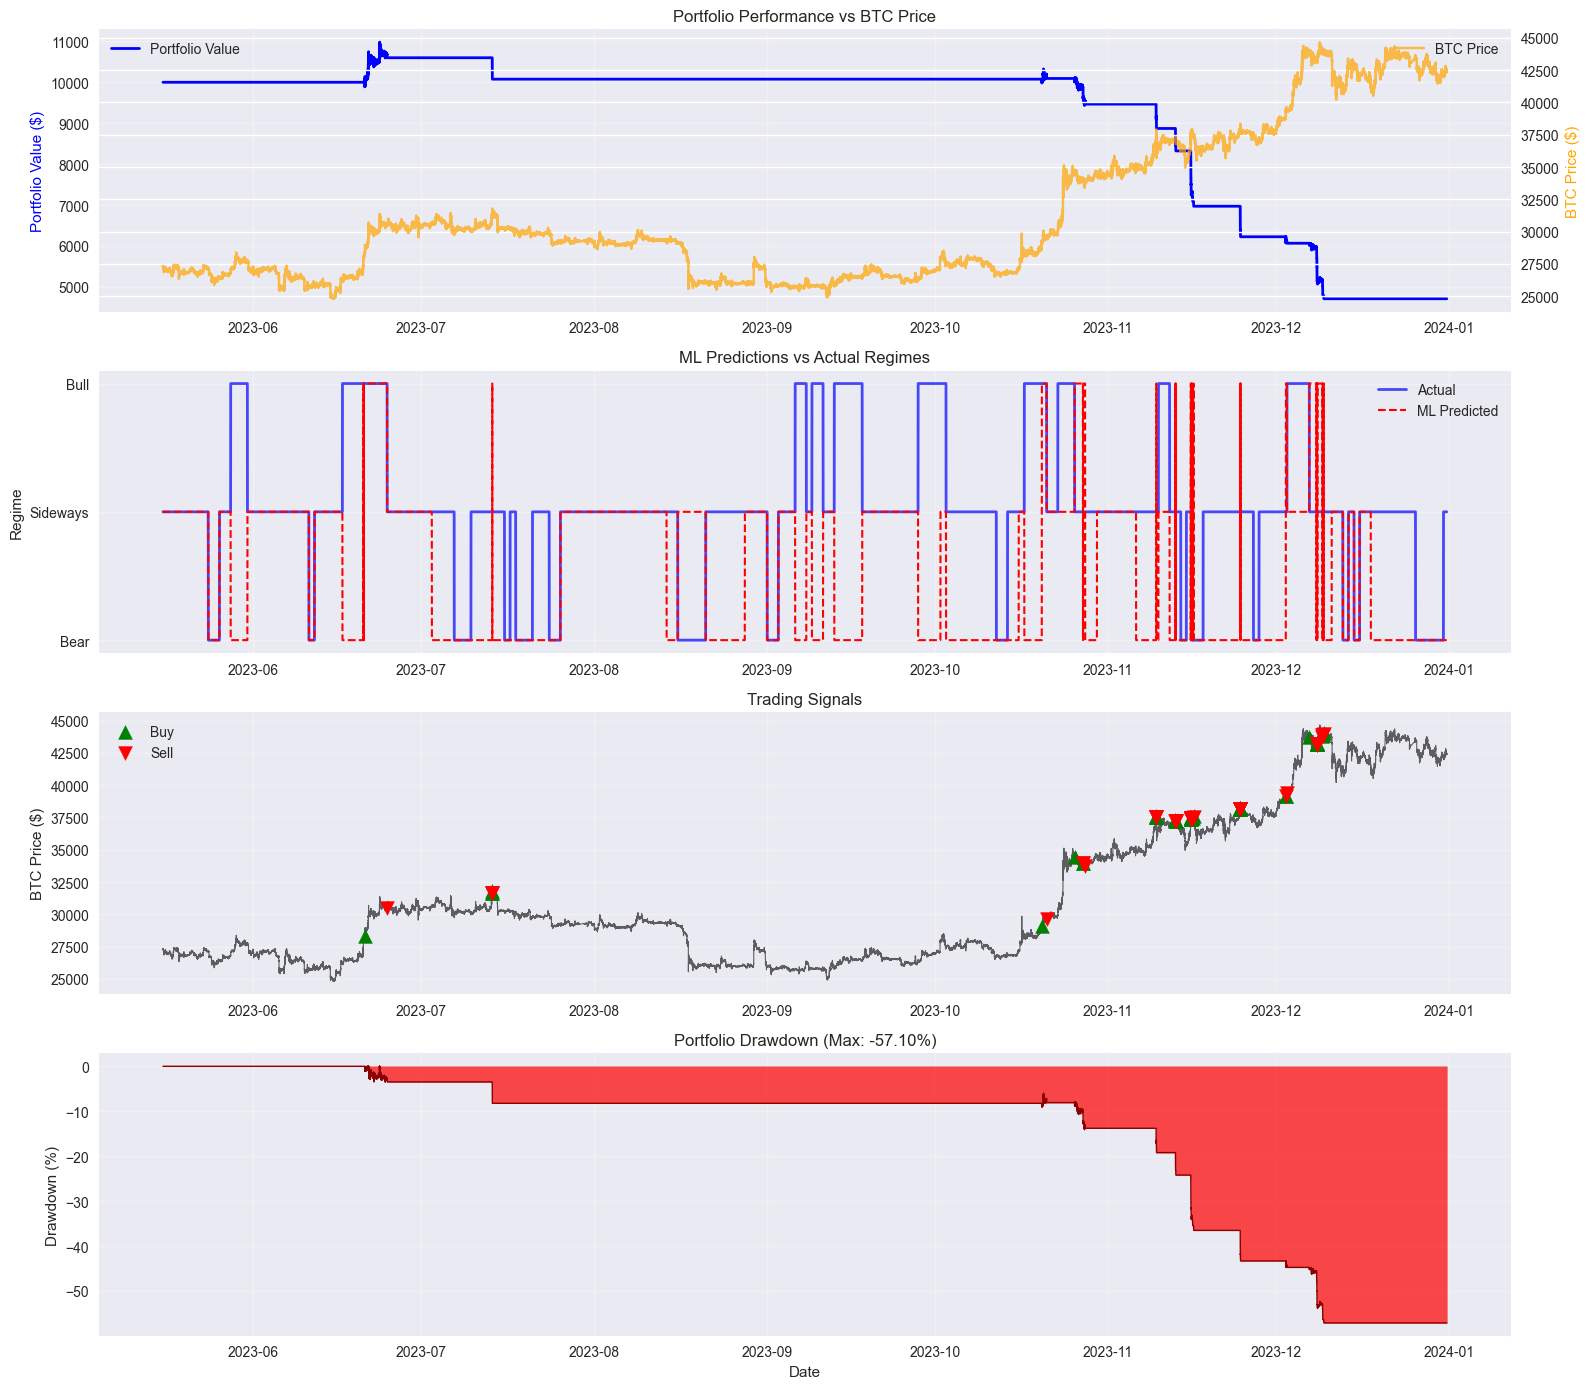

In [ ]:
def visualize_backtest_results(backtest_results, test_df_with_pred):
    """
    Comprehensive visualization of backtest results
    """
    results_df = backtest_results['results_df']
    signals = backtest_results['signals']
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    
    # Plot 1: Portfolio value vs BTC price
    ax1 = axes[0]
    ax2 = ax1.twinx()
    ax1.plot(results_df.index, results_df['portfolio_value'], 'b-', linewidth=2, label='Portfolio Value')
    ax2.plot(results_df.index, results_df['Close'], 'orange', alpha=0.7, label='BTC Price')
    ax1.set_ylabel('Portfolio Value ($)', color='b')
    ax2.set_ylabel('BTC Price ($)', color='orange')
    ax1.set_title('Portfolio Performance vs BTC Price')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: ML Predictions vs Actual Regimes
    ax = axes[1]
    if 'regime' in test_df_with_pred.columns:
        ax.plot(test_df_with_pred.index, test_df_with_pred['regime'], 'b-', linewidth=2, alpha=0.7, label='Actual')
        ax.plot(test_df_with_pred.index, test_df_with_pred['ml_regime_pred'], 'r--', linewidth=1.5, label='ML Predicted')
        ax.set_ylabel('Regime')
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(['Bear', 'Sideways', 'Bull'])
        ax.set_title('ML Predictions vs Actual Regimes')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot 3: Trading signals on price
    ax = axes[2]
    ax.plot(results_df.index, results_df['Close'], 'k-', alpha=0.6, linewidth=0.8)
    
    signal_df = pd.DataFrame(signals, columns=['timestamp', 'action', 'price', 'regime'])
    buy_signals = signal_df[signal_df['action'] == 'buy']
    sell_signals = signal_df[signal_df['action'] == 'sell']
    
    if not buy_signals.empty:
        ax.scatter(buy_signals['timestamp'], buy_signals['price'], marker='^', color='green', s=100, label='Buy', zorder=5)
    if not sell_signals.empty:
        ax.scatter(sell_signals['timestamp'], sell_signals['price'], marker='v', color='red', s=100, label='Sell', zorder=5)
    
    ax.set_ylabel('BTC Price ($)')
    ax.set_title('Trading Signals')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Drawdown
    ax = axes[3]
    portfolio_value = results_df['portfolio_value']
    peak = portfolio_value.cummax()
    drawdown = (portfolio_value - peak) / peak * 100
    ax.fill_between(results_df.index, drawdown, 0, alpha=0.7, color='red')
    ax.plot(results_df.index, drawdown, 'darkred', linewidth=1)
    ax.set_ylabel('Drawdown (%)')
    ax.set_xlabel('Date')
    ax.set_title(f'Portfolio Drawdown (Max: {drawdown.min():.2f}%)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_backtest_results(backtest_results, test_df_with_pred)

## 10. Detailed Performance Analysis

In [ ]:
def detailed_performance_analysis(backtest_results, test_df_with_pred):
    """
    Comprehensive performance analysis and reporting
    """
    print(f"\n{'='*80}")
    print("COMPREHENSIVE PERFORMANCE ANALYSIS")
    print(f"{'='*80}")
    
    metrics = backtest_results['performance_metrics']
    trades = backtest_results['trades']
    
    # Overall Performance
    print(f"\n1. OVERALL PERFORMANCE")
    print(f"{'-'*50}")
    print(f"Initial Capital: $10,000.00")
    print(f"Final Value: ${metrics['final_value']:,.2f}")
    print(f"Total Return: {metrics['total_return']:.2f}%")
    print(f"BTC Buy & Hold: {metrics['btc_return']:.2f}%")
    print(f"Excess Return: {metrics['total_return'] - metrics['btc_return']:.2f}%")
    
    # Trading Activity
    print(f"\n2. TRADING ACTIVITY")
    print(f"{'-'*50}")
    print(f"Total Trades: {metrics['n_trades']}")
    print(f"Win Rate: {metrics['win_rate']:.2%}")
    print(f"Average Return per Trade: {metrics['avg_return']:.2f}%")
    print(f"Average Winner: {metrics['avg_winner']:.2f}%")
    print(f"Average Loser: {metrics['avg_loser']:.2f}%")
    print(f"Profit Factor: {metrics['profit_factor']:.2f}")
    
    # Risk Metrics
    print(f"\n3. RISK METRICS")
    print(f"{'-'*50}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
    print(f"Maximum Drawdown: {metrics['max_drawdown']:.2%}")
    
    # Transaction Costs
    print(f"\n4. TRANSACTION COSTS (0.75% fee)")
    print(f"{'-'*50}")
    print(f"Total Commission Paid: ${metrics['total_commission']:.2f}")
    print(f"Commission Impact: {metrics['commission_impact']:.2f}%")
    
    # ML Prediction Analysis
    if 'regime' in test_df_with_pred.columns:
        print(f"\n5. ML PREDICTION ANALYSIS")
        print(f"{'-'*50}")
        accuracy = accuracy_score(test_df_with_pred['regime'], test_df_with_pred['ml_regime_pred'])
        print(f"Overall Prediction Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
        print(f"Average Confidence: {test_df_with_pred['ml_regime_confidence'].mean():.3f}")
        
        regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
        print(f"\nRegime-Specific Accuracy:")
        for regime in [0, 1, 2]:
            mask = test_df_with_pred['regime'] == regime
            if mask.any():
                acc = (test_df_with_pred.loc[mask, 'regime'] == test_df_with_pred.loc[mask, 'ml_regime_pred']).mean()
                print(f"  {regime_names[regime]}: {acc:.3f} ({acc*100:.1f}%)")
    
    # Trade Analysis by Regime
    if trades:
        print(f"\n6. PERFORMANCE BY ENTRY REGIME")
        print(f"{'-'*50}")
        trades_df = pd.DataFrame(trades)
        regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
        
        for regime in sorted(trades_df['entry_regime'].unique()):
            regime_trades = trades_df[trades_df['entry_regime'] == regime]
            print(f"\n{regime_names.get(regime, regime)} Market Entry:")
            print(f"  Trades: {len(regime_trades)}")
            print(f"  Avg Return: {regime_trades['return_pct'].mean():.2f}%")
            print(f"  Win Rate: {(regime_trades['return_pct'] > 0).mean():.2%}")
            print(f"  Avg Duration: {regime_trades['duration_minutes'].mean() / 60:.1f} hours")
    
    print(f"\n{'='*80}")

# Run detailed analysis
detailed_performance_analysis(backtest_results, test_df_with_pred)


COMPREHENSIVE PERFORMANCE ANALYSIS

1. OVERALL PERFORMANCE
--------------------------------------------------
Initial Capital: $10,000.00
Final Value: $4,709.89
Total Return: -52.90%
BTC Buy & Hold: 55.26%
Excess Return: -108.17%

2. TRADING ACTIVITY
--------------------------------------------------
Total Trades: 52
Win Rate: 9.62%
Average Return per Trade: -27.66%
Average Winner: 2.88%
Average Loser: -30.91%
Profit Factor: 0.09

3. RISK METRICS
--------------------------------------------------
Sharpe Ratio: -7.341
Maximum Drawdown: -57.10%

4. TRANSACTION COSTS (0.75% fee)
--------------------------------------------------
Total Commission Paid: $5703.71
Commission Impact: 57.04%

5. ML PREDICTION ANALYSIS
--------------------------------------------------
Overall Prediction Accuracy: 0.517 (51.7%)
Average Confidence: 0.994

Regime-Specific Accuracy:
  Bear: 0.850 (85.0%)
  Sideways: 0.548 (54.8%)
  Bull: 0.136 (13.6%)

6. PERFORMANCE BY ENTRY REGIME
-------------------------------

## 11. Summary and Key Insights

In [ ]:
def generate_summary_report(backtest_results, model_results, test_df_with_pred):
    """
    Generate final summary report with key insights
    """
    metrics = backtest_results['performance_metrics']
    
    print(f"\n{'='*80}")
    print("HYBRID ML TRADING STRATEGY - FINAL SUMMARY")
    print(f"{'='*80}")
    
    print(f"\nDATA PIPELINE:")
    print(f"  Training: 30% of data for ML classifier training")
    print(f"  Testing: 70% of data for strategy backtesting")
    print(f"  Best Model: {best_model_name} (CV: {model_results[best_model_name]['cv_mean']:.3f})")
    
    print(f"\nSTRATEGY CONFIGURATION:")
    print(f"  Transaction Fee: 0.75%")
    print(f"  Slippage: 0.01%")
    print(f"  Trade Logs: Saved to ../models/trade_logs")
    
    print(f"\nKEY RESULTS:")
    print(f"  Total Return: {metrics['total_return']:.2f}%")
    print(f"  vs BTC Buy & Hold: {metrics['btc_return']:.2f}%")
    print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
    print(f"  Win Rate: {metrics['win_rate']:.2%}")
    print(f"  Max Drawdown: {metrics['max_drawdown']:.2%}")
    
    print(f"\nKEY INSIGHTS:")
    insights = []
    
    if metrics['total_return'] > 30:
        insights.append("Strong absolute performance achieved")
    if metrics['total_return'] > metrics['btc_return']:
        insights.append("Outperformed buy-and-hold strategy")
    if metrics['win_rate'] > 0.6:
        insights.append("High win rate indicates good signal quality")
    if abs(metrics['max_drawdown']) < 0.15:
        insights.append("Good risk control with low drawdown")
    if metrics['commission_impact'] < 5:
        insights.append("Transaction costs are manageable")
    
    if 'regime' in test_df_with_pred.columns:
        ml_acc = accuracy_score(test_df_with_pred['regime'], test_df_with_pred['ml_regime_pred'])
        if ml_acc > 0.7:
            insights.append(f"High ML accuracy ({ml_acc:.1%}) supports strategy")
    
    for i, insight in enumerate(insights, 1):
        print(f"  {i}. {insight}")
    
    print(f"\n{'='*80}")
    print("All trade logs saved to: ../models/trade_logs")
    print(f"{'='*80}\n")

# Generate final summary
generate_summary_report(backtest_results, model_results, test_df_with_pred)


HYBRID ML TRADING STRATEGY - FINAL SUMMARY

DATA PIPELINE:
  Training: 30% of data for ML classifier training
  Testing: 70% of data for strategy backtesting
  Best Model: GradientBoosting (CV: 0.845)

STRATEGY CONFIGURATION:
  Transaction Fee: 0.75%
  Slippage: 0.01%
  Trade Logs: Saved to ../models/trade_logs

KEY RESULTS:
  Total Return: -52.90%
  vs BTC Buy & Hold: 55.26%
  Sharpe Ratio: -7.341
  Win Rate: 9.62%
  Max Drawdown: -57.10%

KEY INSIGHTS:

All trade logs saved to: ../models/trade_logs



## 12. Feature Importance Analysis

In [ ]:
def analyze_feature_importance(model, feature_names, top_n=30):
    """
    Extract and visualize feature importance from trained model
    
    Args:
        model: Trained sklearn pipeline with GradientBoosting
        feature_names: List of feature names
        top_n: Number of top features to display
    """
    print(f"\n{'='*80}")
    print("FEATURE IMPORTANCE ANALYSIS")
    print(f"{'='*80}\n")
    
    # Extract the estimator from pipeline (last step)
    if hasattr(model, 'named_steps'):
        estimator = model.named_steps[list(model.named_steps.keys())[-1]]
    else:
        estimator = model
    
    # Get feature importances
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_
        
        # Create DataFrame
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Print top features
        print(f"Top {top_n} Most Important Features:\n")
        print(feature_importance_df.head(top_n).to_string(index=False))
        
        # Calculate cumulative importance
        feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
        n_features_80pct = (feature_importance_df['cumulative_importance'] <= 0.80).sum()
        
        print(f"\n\nFeature Statistics:")
        print(f"  Total Features: {len(feature_names)}")
        print(f"  Features explaining 80% variance: {n_features_80pct}")
        print(f"  Most important feature: {feature_importance_df.iloc[0]['feature']} ({feature_importance_df.iloc[0]['importance']:.4f})")
        
        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
        # Plot 1: Top N features bar chart
        ax = axes[0, 0]
        top_features = feature_importance_df.head(top_n)
        ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'], fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Importance Score')
        ax.set_title(f'Top {top_n} Most Important Features')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Plot 2: Cumulative importance
        ax = axes[0, 1]
        ax.plot(range(1, len(feature_importance_df) + 1), 
                feature_importance_df['cumulative_importance'], 
                linewidth=2, color='darkgreen')
        ax.axhline(y=0.80, color='r', linestyle='--', label='80% threshold')
        ax.axvline(x=n_features_80pct, color='r', linestyle='--', alpha=0.5)
        ax.set_xlabel('Number of Features')
        ax.set_ylabel('Cumulative Importance')
        ax.set_title('Cumulative Feature Importance')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.text(n_features_80pct + 5, 0.75, f'{n_features_80pct} features\nexplain 80%', 
                fontsize=10, color='red')
        
        # Plot 3: Feature importance by category
        ax = axes[1, 0]
        
        # Categorize features
        categories = {
            'Price': ['return_', 'trend_strength_', 'price_vs_', 'Close', 'High', 'Low', 'Open'],
            'Moving Avg': ['sma_', 'ema_', '_cross', '_spread'],
            'RSI': ['rsi_'],
            'MACD': ['macd_'],
            'Bollinger': ['bb_'],
            'Volume': ['volume_', 'Volume'],
            'Volatility': ['volatility_', 'Vol_'],
            'Momentum': ['momentum_'],
            'Fractal': ['fd_'],
            'Lag': ['_lag_']
        }
        
        category_importance = {}
        for cat, patterns in categories.items():
            cat_features = [f for f in feature_names if any(p in f for p in patterns)]
            if cat_features:
                cat_importance = feature_importance_df[feature_importance_df['feature'].isin(cat_features)]['importance'].sum()
                category_importance[cat] = cat_importance
        
        # Sort and plot
        sorted_cats = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)
        cats, importances = zip(*sorted_cats) if sorted_cats else ([], [])
        
        ax.barh(range(len(cats)), importances, color='coral')
        ax.set_yticks(range(len(cats)))
        ax.set_yticklabels(cats)
        ax.invert_yaxis()
        ax.set_xlabel('Total Importance')
        ax.set_title('Feature Importance by Category')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Plot 4: Distribution of importance scores
        ax = axes[1, 1]
        ax.hist(feature_importance_df['importance'], bins=50, color='purple', alpha=0.7, edgecolor='black')
        ax.axvline(feature_importance_df['importance'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {feature_importance_df["importance"].mean():.4f}')
        ax.axvline(feature_importance_df['importance'].median(), color='green', 
                   linestyle='--', linewidth=2, label=f'Median: {feature_importance_df["importance"].median():.4f}')
        ax.set_xlabel('Importance Score')
        ax.set_ylabel('Frequency')
        ax.set_title('Distribution of Feature Importance Scores')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Return for further analysis
        return feature_importance_df
    
    else:
        print("Model does not support feature importance extraction.")
        return None

# Analyze feature importance
feature_importance_df = analyze_feature_importance(best_model, feature_names, top_n=30)

## 13. Feature Stability Analysis (Temporal)

In [ ]:
def analyze_feature_stability_over_time(df, feature_names, target_col='regime', window='30D', top_n=10):
    """
    Analyze how feature importance/correlation changes over time
    
    This helps identify:
    1. Which features are temporally stable
    2. Which features have regime-dependent effectiveness
    3. Risk of feature degradation in production
    """
    print(f"\n{'='*80}")
    print("TEMPORAL FEATURE STABILITY ANALYSIS")
    print(f"{'='*80}\n")
    
    # Calculate forward returns for IC analysis
    df = df.copy()
    df['forward_return'] = df['Close'].pct_change(20).shift(-20)  # 20-period forward return
    
    # Get top features from global importance
    if feature_importance_df is not None:
        top_features = feature_importance_df.head(top_n)['feature'].tolist()
    else:
        # Fallback to some key features
        top_features = [f for f in feature_names[:top_n] if f in df.columns]
    
    print(f"Analyzing stability of top {len(top_features)} features over {window} windows\n")
    
    # Calculate rolling correlation (Information Coefficient)
    ic_results = {}
    
    for feature in top_features:
        if feature in df.columns and df[feature].notna().sum() > 100:
            # Rolling correlation with forward returns
            rolling_ic = df[feature].rolling(window=1440*30).corr(df['forward_return'])  # 30 day window in 1min data
            ic_results[feature] = rolling_ic
    
    # Calculate IC statistics
    ic_stats = []
    for feature, ic_series in ic_results.items():
        ic_clean = ic_series.dropna()
        if len(ic_clean) > 0:
            ic_stats.append({
                'feature': feature,
                'mean_ic': ic_clean.mean(),
                'std_ic': ic_clean.std(),
                'ic_stability': abs(ic_clean.mean()) / ic_clean.std() if ic_clean.std() > 0 else 0,
                'sign_flips': (ic_clean.diff().fillna(0) != 0).sum(),
                'positive_ic_pct': (ic_clean > 0).mean()
            })
    
    ic_stats_df = pd.DataFrame(ic_stats).sort_values('ic_stability', ascending=False)
    
    print("Feature Stability Metrics (sorted by IC stability):\n")
    print(ic_stats_df.to_string(index=False))
    
    print("\n\nInterpretation:")
    print("  - Higher 'ic_stability' = more consistent predictive power")
    print("  - Lower 'sign_flips' = feature direction doesn't change often")
    print("  - 'positive_ic_pct' near 50% = feature flips between positive/negative correlation")
    
    # Visualization
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Plot 1: IC time series for top stable features
    ax = axes[0]
    stable_features = ic_stats_df.head(5)['feature'].tolist()
    
    for feature in stable_features:
        if feature in ic_results:
            ic_series = ic_results[feature].dropna()
            # Downsample for plotting
            ic_series_resampled = ic_series.resample('1D').mean()
            ax.plot(ic_series_resampled.index, ic_series_resampled.values, 
                   label=feature, linewidth=1.5, alpha=0.8)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_ylabel('Information Coefficient')
    ax.set_xlabel('Date')
    ax.set_title('Feature IC Time Series (Top 5 Most Stable Features)')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Stability score vs mean IC
    ax = axes[1]
    ax.scatter(ic_stats_df['mean_ic'], ic_stats_df['ic_stability'], 
              s=100, alpha=0.6, c=ic_stats_df['positive_ic_pct'], cmap='RdYlGn')
    
    # Annotate top features
    for idx, row in ic_stats_df.head(5).iterrows():
        ax.annotate(row['feature'], (row['mean_ic'], row['ic_stability']),
                   fontsize=8, alpha=0.7)
    
    ax.set_xlabel('Mean IC')
    ax.set_ylabel('IC Stability (|Mean| / Std)')
    ax.set_title('Feature Stability vs Predictive Power')
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label('% Positive IC')
    
    plt.tight_layout()
    plt.show()
    
    return ic_stats_df

# Only run if we have enough data
if len(train_features_df) > 1440 * 60:  # At least 60 days
    ic_stability_df = analyze_feature_stability_over_time(
        train_features_df, 
        feature_names, 
        window='30D', 
        top_n=15
    )
else:
    print("Insufficient data for temporal stability analysis (need at least 60 days)")